# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [29]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings("ignore")

In [30]:
df = pd.read_csv('tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
4563,9342,54294,"Bradford, UK",19-03-2020,Let's appreciate how brilliant supermarket sta...,Extremely Positive
19429,27454,72406,New York and the World,26-03-2020,Lime and Bird are rethinking their business st...,Negative
18044,25756,70708,"Perth, Wild West Australia",25-03-2020,good to see that after pubs and clubs are clos...,Positive
18494,26305,71257,one Earth one human,25-03-2020,We need Mass production of SANITIZER.. \r\r\nN...,Extremely Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [31]:
df['Sentiment'] = df['Sentiment'].apply(lambda x: 1 if x == 'Positive' or x == 'Extremely Positive' else 0)

Сбалансированы ли классы?

In [32]:
df[df['Sentiment'] == 1].shape

(18046, 6)

In [33]:
df[df['Sentiment'] == 0].shape

(15398, 6)

**Ответ:** Классы приблизительно сбалансированный, они отличаются друг от друга, но не намного

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [34]:
df.isna().sum()

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [35]:
df['Location'] = df['Location'].fillna('Unknown')

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [36]:
X = df.drop(columns = ['Sentiment'])
y = df['Sentiment']

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, \
                              test_size=0.3,\
                              shuffle=True,
                              random_state=0)

In [38]:
X_train

,UserName,ScreenName,Location,TweetAt,OriginalTweet
25621,35178,80130,Unknown,06-04-2020,Why we still want to buy so much stuff during ...
30135,40819,85771,"Boston, MA HQ",10-04-2020,With driving even more usage a strong strategy...
28899,39249,84201,India,09-04-2020,@Canon_India I am very happy.. Great job by @C...
5989,11068,56020,"Mayfair, London, UK",19-03-2020,The U.S national debt will likely exceed $30 T...
4367,9109,54061,WNC,18-03-2020,"Finally got to the grocery store. Honestly, wh..."
...,...,...,...,...,...
20757,29120,74072,Unknown,31-03-2020,Football is in ruins right now.When it will re...
32103,43291,88243,"Waterville, Ireland Austin, TX",13-04-2020,Hand sanitizer made here on the Skellig Coast!...
30403,41159,86111,"Mumbai , Delhi India",10-04-2020,An initiative taken by our @GOLDENINITIATI1 ...
21243,29702,74654,Unknown,01-04-2020,Vile premiership players demanding full wages ...


## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [39]:
token_counts=dict()

for tweet in X_train['OriginalTweet']:
    tokens = tweet.lower().split()
    for token in tokens:
        if token in token_counts:
            token_counts[token] += 1
        else:
            token_counts[token] = 1

Какой размер словаря получился?

In [40]:
len(token_counts)

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [41]:
sorted_tokens = sorted(token_counts.items(), key = lambda x: x[1], reverse = True)
top_ten_tokens = sorted_tokens[:10]
print(top_ten_tokens)

[('the', 26815), ('to', 23373), ('and', 14684), ('of', 13012), ('a', 11737), ('in', 11198), ('for', 8566), ('#coronavirus', 8223), ('is', 7383), ('are', 7050)]


**Ответ:** Наиболее часто встречающиеся токены это артикли и предлоги, поскольку они являются основой для построения предложения и будут употребляться намного больше, чем любые другие слова

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [42]:
import nltk
from nltk.corpus import stopwords

stop_words = stopwords.words("english")

filtered_token_counts = [(key, value) for key, value in token_counts.items() if key not in stop_words]

top_10_filtered_tokens = sorted(filtered_token_counts, key=lambda x: x[1], reverse=True)[:10]

print(top_10_filtered_tokens)

[('#coronavirus', 8223), ('prices', 3891), ('food', 3820), ('grocery', 3469), ('supermarket', 3288), ('people', 3175), ('covid-19', 3173), ('store', 3155), ('#covid19', 2471), ('&amp;', 2314)]


**Ответ:**  Эти токены уже имеют какой-то содержательный смылсл, некоторые из них являются хештегами, некоторые словами из твитов

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [43]:
least_popular_tokens =  sorted(filtered_token_counts, key=lambda x: x[1], reverse=False)[:20]
print(least_popular_tokens)

[('https://t.co/1m881cwfuv', 1), ('happy..', 1), ('https://t.co/z0intks34x', 1), ('mnuchinã\x82â\x92s', 1), ('brink.', 1), ('https://t.co/jmobv8z0u0', 1), ("university's", 1), ('teaching.)', 1), ('@catholicpres', 1), ('@catholicuniv', 1), ('https://t.co/evqby035wf', 1), ('https://t.co/riqrhxxeim', 1), ('@@ballardspahrll', 1), ('#aca', 1), ('easier...take', 1), ('ã\x82â\x93necessaryã\x82â\x94', 1), ('https://t.co/0fmsmlgepm', 1), ('husted:', 1), ('irishman', 1), ('#happystpatricksday!', 1)]


**Ответ:** В списке 20 самых непопулярных слов находятся ссылки на другие посты и других людей, что имеет смысл только в конкретном (единочном) контексте, поэтому они встречаются только один раз

Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [44]:
from nltk.tokenize import TweetTokenizer

tweet_token_counts = dict()
tw = TweetTokenizer()
for tweet in X_train['OriginalTweet']:
    tokens = tw.tokenize(tweet)
    for token in tokens:
        if token in tweet_token_counts:
            tweet_token_counts[token] += 1
        else:
            tweet_token_counts[token] = 1
sorted_tweet_tokens = sorted(tweet_token_counts.items(), key = lambda x: x[1], reverse = True)
top_ten_tweet_tokens = sorted_tweet_tokens[:10]
print(top_ten_tweet_tokens)

[('the', 24337), ('.', 24118), ('to', 22933), (',', 17571), ('and', 14354), ('of', 12904), ('a', 11045), ('in', 10573), ('?', 9524), ('for', 8228)]


**Ответ:** С помощью токенайзера TweetTokenizer наиболее популярные токены стали также предлоги и еще пунктуация, поскольку TweetTokenizer учитывает все символы (это необходимо для фиксации смайликов)

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [45]:
from string import punctuation

noise = stopwords.words("english") + list(punctuation)

filtered_tweet_token_counts = {key: value for key, value in tweet_token_counts.items() if key not in noise}

top_10_filtered_tweet_tokens = sorted(filtered_tweet_token_counts.items(), key=lambda x: x[1], reverse=True)[:10]

print(top_10_filtered_tweet_tokens)

[('Â', 7415), ('\x82', 7311), ('19', 7167), ('#coronavirus', 7143), ('I', 5235), ('\x92', 4372), ('prices', 4281), ('COVID', 4218), ('food', 3795), ('store', 3691)]


**Ответ:** Теперь в топ-10 входят отдельные буквы, цифры, слова и хештеги, однако буквы и цифры не подлежат содержательной интерпретации, поэтому необходимо доработать этот способ анализа твитов

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [46]:
filtered_tweet_token_counts_new = {key: value for key, value in filtered_tweet_token_counts.items() if len(key) != 1 or ord(key) < 128}

top_10_popular_tokens = sorted(filtered_tweet_token_counts_new.items(), key=lambda x: x[1], reverse=True)[:10]
top_20_unpopular_tokens = sorted(filtered_tweet_token_counts_new.items(), key=lambda x: x[1])[:20]

print("Топ-10 популярных слов:", top_10_popular_tokens)

print("\nТоп-20 непопулярных слов:", top_20_unpopular_tokens)

Топ-10 популярных слов: [('19', 7167), ('#coronavirus', 7143), ('I', 5235), ('prices', 4281), ('COVID', 4218), ('food', 3795), ('store', 3691), ('supermarket', 3373), ('grocery', 3083), ('people', 3047)]

Топ-20 непопулярных слов: [('https://t.co/1m881CwFUv', 1), ('https://t.co/Z0intkS34x', 1), ('MnuchinÃ', 1), ('https://t.co/JmoBv8z0U0', 1), ("University's", 1), ('@CatholicPres', 1), ('@CatholicUniv', 1), ('https://t.co/EvQby035wF', 1), ('https://t.co/rIQrhxxeIM', 1), ('@BallardSpahrLL', 1), ('#training', 1), ('#aca', 1), ('https://t.co/0FmSmlGePM', 1), ('Irishman', 1), ('#HappyStPatricksDay', 1), ('Guiness', 1), ('https://t.co/18V0PYHwb7', 1), ('https://t.co/LS0g86i8PU', 1), ('https://t.co/oFVkejfF23', 1), ('https://t.co/Xoodgd2uLx', 1)]


**Ответ:** Данный код убрал не все буквы и цифры, он удалил A, \x82, однако не убрал 19 и I. Можно предположить, что цифра 19 нужна нам для интерпретации, однако однозначно местоимение I неп подлежит никакой интерпретации.

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [47]:
hashtags = {key: value for key, value in filtered_tweet_token_counts_new.items() if key.startswith("#")}
top_10_hashtags = sorted(hashtags.items(), key=lambda x: x[1], reverse=True)[:10]
print(top_10_hashtags)

[('#coronavirus', 7143), ('#COVID19', 1844), ('#Covid_19', 1463), ('#Coronavirus', 1281), ('#COVID2019', 927), ('#toiletpaper', 657), ('#covid19', 568), ('#COVID', 542), ('#CoronaCrisis', 426), ('#CoronaVirus', 351)]


**Ответ:** Все топ-10 популярных хештегов связаны с короновирусом, написанные в разном формате

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [48]:
links = {key: value for key, value in filtered_tweet_token_counts_new.items() if key.startswith("https://t.co")}
top_10_links = sorted(links.items(), key=lambda x: x[1], reverse=True)[:10]
print(top_10_links)

[('https://t.co/oXA7SWtoNd', 5), ('https://t.co/gP3EusapL8', 4), ('https://t.co/DefTruI1PfÃ\x82Â', 3), ('https://t.co/WrLHYzIzAA', 3), ('https://t.co/kuwIpF1KQW', 3), ('https://t.co/zjNRx6dKKN', 3), ('https://t.co/3GBBDpdjat', 3), ('https://t.co/e2ZNXajPre', 3), ('https://t.co/CATKegAyOY', 3), ('https://t.co/G63RP042HO', 3)]


**Ответ:** Популярность ссылки не сравнима с популярностью хэштегов, популярность ссылок в разы меньше популярности хэштегов. Информация о ссылки вряд ли будет информативна, поскольку с учетом размера нашей выборки частота встречаемости ссылок нерепрезентативна и по ним нельзя сделать никаких содержательных выводов.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [49]:
def custom_tokenizer(text):
    
    text_to_tokenize = text.lower()
    tw = TweetTokenizer()
    text_to_filter = tw.tokenize(text_to_tokenize)
    
    noise = stopwords.words("english") + list(punctuation)
    tokens = [x for x in text_to_filter if (x not in noise) and ('https://t.co' not in x) and (all(ord(char) < 128 for char in x))]
    
    return tokens

In [50]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
X_cv = cv.fit_transform(X_train['OriginalTweet'])
X_cv_test = cv.transform(X_test['OriginalTweet'])

print(len(cv.vocabulary_))

44130


**Ответ:** При помощи  CountVectorizer полученный словарь стал меньше изначального, скоратившись практически в два раза

Посмотрим на какой-нибудь конкретный твитт:

In [52]:
ind = 9023
df.iloc[ind]['OriginalTweet'], df.iloc[ind]['Sentiment']

("Shop keepers taking advantage of #Coronavirus boosting prices disproportionately so the most Marginalised suffer who can't afford it #SHAMEONYOU #Wewillremember",
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [53]:
tweet = ["Shop keepers taking advantage of #Coronavirus boosting prices disproportionately so the most Marginalised suffer who can't afford it #SHAMEONYOU #Wewillremember"]

tweet_vectorised = cv.transform(tweet)

max_index = tweet_vectorised.toarray().argmax()
min_index = tweet_vectorised.toarray().argmin()

max_token = list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(max_index)]
min_token = list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(min_index)]

print("Самый популярный токен:", max_token)
print("Самый непопулярный токкен:", min_token)

Самый популярный токен: #coronavirus
Самый непопулярный токкен: ###covid-19


**Ответ:** Двумя самыми важными и самыми неважными токенами являются слова, связанные с ковидом. Токены определились плохо, провести интрепретацию будет сложно, если не невозможно

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=custom_tokenizer)
X_vec = vec.fit_transform(X_train['OriginalTweet'])
X_vec_test = vec.transform(X_test['OriginalTweet'])

In [55]:
tweet_vectorised_tfid = vec.transform(tweet)

max_index_tfid = tweet_vectorised_tfid.toarray().argmax()
min_index_tfid = tweet_vectorised_tfid.toarray().argmin()

max_token_tfid = list(vec.vocabulary_.keys())[list(vec.vocabulary_.values()).index(max_index_tfid)]
min_token_tfid = list(vec.vocabulary_.keys())[list(vec.vocabulary_.values()).index(min_index_tfid)]

print("Самый популярный токен:", max_token_tfid)
print("Самый непопулярный токен:", min_token_tfid)

Самый популярный токен: #wewillremember
Самый непопулярный токен: ###covid-19


**Ответ:** Данная токенизация выглядит намного лучше, она содержит разные значения токенов и подлежит содержательной интерпретации

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [56]:
df[df['OriginalTweet'].apply(lambda x: 'good' in x) & (df['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,1
101,3920,48872,Unknown,16-03-2020,I love this ?? all grocery stores should have ...,1
114,3933,48885,Malaysia,16-03-2020,Good move in tackling down the Covid-19 spread...,1
192,4035,48987,"San Diego, CA",16-03-2020,"What's a good way to support grocery store, me...",1
372,4251,49203,New York City,16-03-2020,Covid-19 is changing consumer purchase habits ...,1
...,...,...,...,...,...,...
33291,44755,89707,New Delhi,14-04-2020,"If you have high blood pressure, it's a good i...",1
33301,44767,89719,Canada,14-04-2020,"We may be saying goodbye to paper flyers soon,...",1
33343,44822,89774,United States,14-04-2020,Remember back in the day when youÃÂd go to t...,1
33346,44826,89778,"Toronto, ONT, Canada",14-04-2020,this deck by .@lukew in insanely good - great ...,1


In [57]:
df.iloc[114]['OriginalTweet'], df.iloc[114]['Sentiment']

('Good move in tackling down the Covid-19 spreading. \r\r\n\r\r\nNow please implement a new policy to restrict consumers from hoarding goods at any supermarket/grocery stores. No point creating safety measurements if some people canÃ\x82Â\x92t be changed from being selfish.',
 1)

In [58]:
tweet_vectorised_tfid = vec.transform(['Good move in tackling down the Covid-19 spreading. \r\r\n\r\r\nNow please implement a new policy to restrict consumers from hoarding goods at any supermarket/grocery stores. No point creating safety measurements if some people canÃ\x82Â\x92t be changed from being selfish.'])

max_index_tfid = tweet_vectorised_tfid.toarray().argmax()
min_index_tfid = tweet_vectorised_tfid.toarray().argmin()

max_token_tfid = list(vec.vocabulary_.keys())[list(vec.vocabulary_.values()).index(max_index_tfid)]
min_token_tfid = list(vec.vocabulary_.keys())[list(vec.vocabulary_.values()).index(min_index_tfid)]

print("Самый популярный токен:", max_token_tfid)
print("Самый непопулярный токен:", min_token_tfid)

Самый популярный токен: measurements
Самый непопулярный токен: ###covid-19


**Ответ:** В самом популярном токене выделятся то, за что человек хвалит правительство. Благодаря этому мы можем определить отношение населения к препренимаемым мерам.

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [59]:
cv_feature_names = cv.get_feature_names_out(())
tfid_feature_names = vec.get_feature_names_out(())

In [60]:
pd.DataFrame(X_cv.toarray(), columns=cv_feature_names)

,###covid-19,##coronavirus,##covid_19,##fda,##stayhomesavelives,#01,#10,#1000,#100daysofcode,#100percent,...,zuku,zumba,zumbuehl,zumindest,zuppardo's,zur,zusendung,zwd,zwoferink,zzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23405,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23407,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23408,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
pd.DataFrame(X_vec.toarray(), columns=tfid_feature_names)

,###covid-19,##coronavirus,##covid_19,##fda,##stayhomesavelives,#01,#10,#1000,#100daysofcode,#100percent,...,zuku,zumba,zumbuehl,zumindest,zuppardo's,zur,zusendung,zwd,zwoferink,zzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(X_cv, y_train)
pred_cv = clf.predict(X_cv_test)
print(f' Accuracy for Count Vectoriser: {accuracy_score(y_test, pred_cv)}')
clf.fit(X_vec, y_train)
pred_vec = clf.predict(X_vec_test)
print(f' Accuracy for TfidfVectorizer: {accuracy_score(y_test, pred_vec)}')

 Accuracy for Count Vectoriser: 0.8651584612318118
 Accuracy for TfidfVectorizer: 0.8525014949172812


**Ответ:** Accuracy на двух моделях примерно одинаков, где Count Vectoriser лидирует на 0.1

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [63]:
from nltk.stem.snowball import SnowballStemmer

In [64]:
def custom_stem_tokenizer(text):
    text_to_tokenize = text.lower()
    tw = TweetTokenizer()
    text_to_filter = tw.tokenize(text_to_tokenize)
    
    stemmer = SnowballStemmer("english")
    text_stemmed = [stemmer.stem(w) for w in text_to_filter]
    
    noise = stopwords.words("english") + list(punctuation)
    tokens = [x for x in text_stemmed if (x not in noise) and ('https://t.co' not in x) and (all(ord(char) < 128 for char in x))]
    
    return tokens

In [65]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [66]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
X_cv = cv.fit_transform(X_train['OriginalTweet'])
X_cv_test = cv.transform(X_test['OriginalTweet'])

print(len(cv.vocabulary_))

35442


In [67]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=custom_stem_tokenizer)
X_vec = vec.fit_transform(X_train['OriginalTweet'])
X_vec_test = vec.transform(X_test['OriginalTweet'])

**Ответ** Словарь сократился еще примерно на 10000

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [68]:
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(X_cv, y_train)
pred_cv = clf.predict(X_cv_test)
print(f' Accuracy for Count Vectoriser: {accuracy_score(y_test, pred_cv)}')
clf.fit(X_vec, y_train)
pred_vec = clf.predict(X_vec_test)
print(f' Accuracy for TfidfVectorizer: {accuracy_score(y_test, pred_vec)}')

 Accuracy for Count Vectoriser: 0.8657564281443093
 Accuracy for TfidfVectorizer: 0.8550926848714371


**Ответ:** Качество улучшилось, но незначительно. Применять стемминг есть смысл, поскольку любое улучшение качества нашей метрики уже хорошо для предсказат

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [69]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=0.3
                        ).fit(X_train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

35441


*Так как мой словарь со стеммингом получился 35442, то дальше я исходила из того, чтобы выполнить задание по инструкции, но только с моей длиной словаря*

**Ответ:** Когда max_df равен 0.3, это означает, что токен будет исключен из словаря, если он встречается в более чем 30% всех документов. Токены, которые встречаются очень часто и, вероятно, не несут много информации о содержании текста (например, слова-помощники, предлоги и т. д.), будут исключены из словаря.

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [70]:
cv_df_2 = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=0.0000000000001
                        ).fit(
                            X_train['OriginalTweet']
                            )
print(len(cv_df_2.vocabulary_))

35442


**Ответ:** В обучающем наборе данных обнаружено 35442 различных слов или токенов, которые были стеммированы  кастомным токенизатором, и каждый из них встречается хотя бы один раз в текстах, но не менее указанного порога (который крайне мал).

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [71]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_cv)
X_test_scaled = scaler.transform(X_cv_test)


clf.fit(X_train_scaled, y_train)

pred_cv = clf.predict(X_test_scaled)
print(f' Accuracy for Count Vectoriser: {accuracy_score(y_test, pred_cv)}')

feature_names = cv.get_feature_names_out()
feature_weights = clf.coef_[0]

top_positive_tokens = [feature_names[i] for i in np.argsort(feature_weights)[-10:]]
top_negative_tokens = [feature_names[i] for i in np.argsort(feature_weights)[:10]]

print(f"Топ 10 токенов с наибольшими по модулю положительными весами: {top_positive_tokens}")
print(f"Топ 10 токенов с наибольшими по модулю отрицательными весами:  {top_negative_tokens}")

 Accuracy for Count Vectoriser: 0.7790512258321706
Топ 10 токенов с наибольшими по модулю положительными весами: ['support', 'best', 'hand', 'sanit', 'great', 'like', 'pleas', 'thank', 'free', 'help']
Топ 10 токенов с наибольшими по модулю отрицательными весами:  ['crisi', 'panic', 'scam', 'demand', 'kill', 'forc', 'fear', 'emerg', 'shit', 'fuck']


**Ответ:** Данные токены с положительными весами свидетельствует о позитивной окраске, в то время как токуны с отрицательными весами говорят о негативной окраски твита. Данные токены можно использовать для предсказания окраски на тестовой выборки

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [72]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy.sparse import hstack

label_encoder = LabelEncoder()
username_encoded = label_encoder.fit_transform(df['UserName'])
screenname_encoded = label_encoder.fit_transform(df['ScreenName'])


hot_encoder = OneHotEncoder()
username_onehot = hot_encoder.fit_transform(username_encoded.reshape(-1, 1))
screenname_onehot = hot_encoder.fit_transform(screenname_encoded.reshape(-1, 1))


username_onehot_train = username_onehot[:len(X_train)]
username_onehot_test = username_onehot[len(X_train):]

screenname_onehot_train = screenname_onehot[:len(X_train)]
screenname_onehot_test = screenname_onehot[len(X_train):]


X_train_combined = hstack((X_train_scaled, username_onehot_train, screenname_onehot_train))
X_test_combined = hstack((X_test_scaled, username_onehot_test, screenname_onehot_test))


logistic_regression_combined = LogisticRegression()
logistic_regression_combined.fit(X_train_combined, y_train)


accuracy_combined = logistic_regression_combined.score(X_test_combined, y_test)
print(accuracy_combined)

0.7813434323300777


**Ответ:** Признаки UserName и ScreenName являются содержательными признаками, поскольку определенные пользователи обычно публикуют твиты с положительной или негативной окраской, что может быть полезно для модели

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

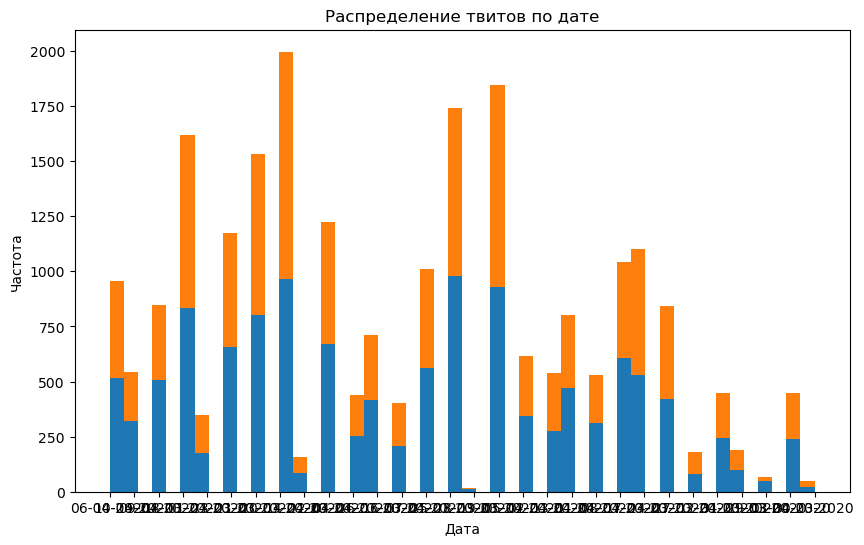

In [73]:
plt.figure(figsize=(10, 6))
plt.hist([X_train['TweetAt'][y_train == 1], X_train['TweetAt'][y_train == 0]],
         stacked=True,
         bins=50,
        )
plt.xlabel('Дата')
plt.ylabel('Частота')
plt.title('Распределение твитов по дате')
plt.show()

In [74]:
date_encoded = label_encoder.fit_transform(df['TweetAt'])
date_onehot = hot_encoder.fit_transform(date_encoded.reshape(-1, 1))

date_onehot_train = date_onehot[:len(X_train)]
date_onehot_test = date_onehot[len(X_train):]

X_train_combined_with_date = hstack((X_train_combined, date_onehot_train))
X_test_combined_with_date = hstack((X_test_combined, date_onehot_test))

logistic_regression_combined = LogisticRegression()
logistic_regression_combined.fit(X_train_combined_with_date, y_train)


accuracy_combined_with_date = logistic_regression_combined.score(X_test_combined_with_date, y_test)
print(accuracy_combined_with_date)

0.782240382698824


**Ответ:** По гистограмме и полученному качеству логистической регрессии мы можем заметить, что переменная TweetAt является значимой для нашей модели

Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [75]:
X_train['Location'].value_counts()

Unknown                           4944
London                             301
United States                      295
London, England                    274
New York, NY                       223
                                  ... 
Work: Kent and Live: Sussex          1
Somewhere on TradingView             1
Honolulu, Hawai?i                    1
SFO                                  1
Waterville, Ireland Austin, TX       1
Name: Location, Length: 7949, dtype: int64

In [76]:
X_train['Location'].isna().sum()

0

7949 уникальных значений

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

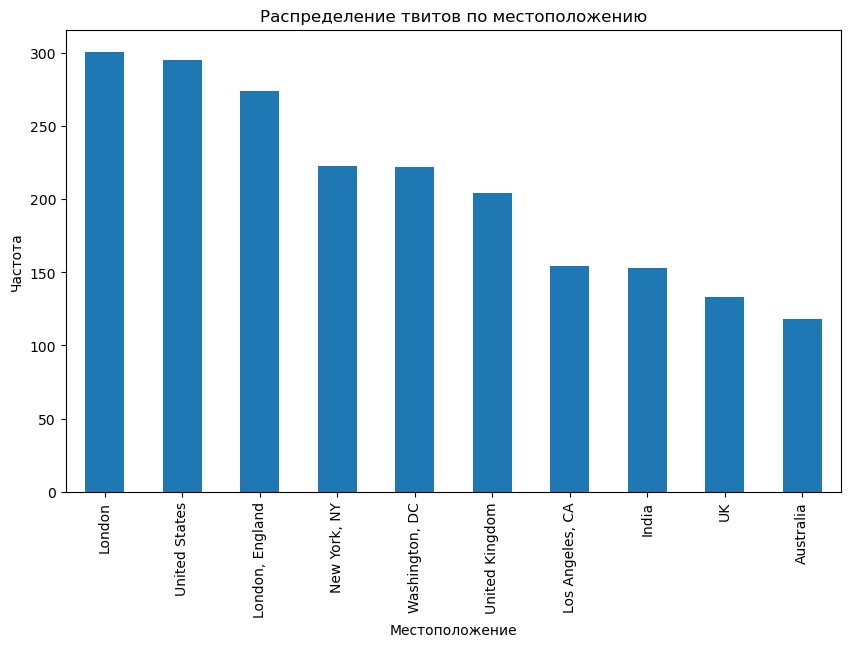

In [77]:
locations = X_train[X_train['Location'] != 'Unknown']['Location']
top_locations = locations.value_counts().head(10)
plt.figure(figsize=(10, 6))
top_locations.plot(kind='bar')
plt.xlabel('Местоположение')
plt.ylabel('Частота')
plt.title('Распределение твитов по местоположению')
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

Number of unique categories in WiderLocation: 5228


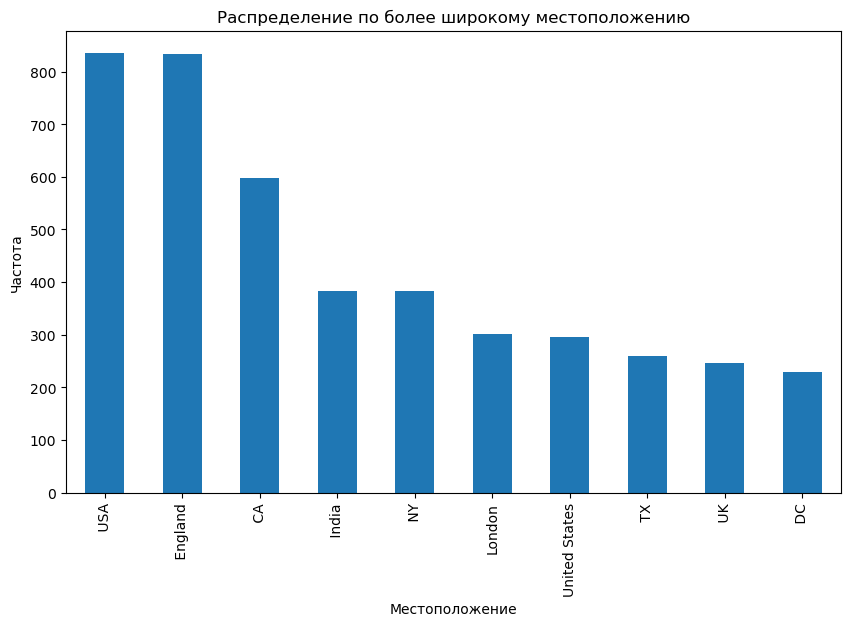

In [78]:
X_train['WiderLocation'] = locations.apply(lambda x: x.split(',')[-1] if ', ' in x else x)
X_train['WiderLocation'] = X_train['WiderLocation'].str.replace('\$\$','\\$\\$')
X_train = X_train.dropna(subset=['WiderLocation'])

num_unique_wider_locations = X_train['WiderLocation'].nunique()
print("Number of unique categories in WiderLocation:", num_unique_wider_locations)

wider_locations = X_train['WiderLocation'].value_counts().head(10)



plt.figure(figsize=(10, 6))
wider_locations.plot(kind='bar')
plt.xlabel('Местоположение')
plt.ylabel('Частота')
plt.title('Распределение по более широкому местоположению')
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [79]:
location_counts = X_train['WiderLocation'].value_counts()

frequent_locations = location_counts[location_counts > 1].index.tolist()

X_train_filtered = X_train[X_train['WiderLocation'].isin(frequent_locations)]

labeled_features = label_encoder.fit_transform(X_train_filtered['WiderLocation'])
encoded_features = hot_encoder.fit_transform(labeled_features.reshape(-1,1))
encoded_feature_names = hot_encoder.get_feature_names(['WiderLocation'])



print(len(frequent_locations))

1152


In [84]:
locations_test = X_test[X_test['Location'] != 'Unknown']['Location']
X_test['WiderLocation'] = locations_test.apply(lambda x: x.split(',')[-1] if ', ' in x else x)
X_test['WiderLocation'] = X_test['WiderLocation'].str.replace('\$\$','\\$\\$')
X_test = X_test.dropna(subset=['WiderLocation'])

location_counts_test = X_test['WiderLocation'].value_counts()

frequent_locations_test = location_counts_test[location_counts_test > 1].index.tolist()

X_test_filtered = X_test[X_test['WiderLocation'].isin(frequent_locations_test)]

labeled_features_test = label_encoder.transform(X_test_filtered['WiderLocation'])
encoded_features_test = hot_encoder.transform(labeled_features_test.reshape(-1,1))

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [85]:
X_train_combined_new = hstack([X_train_combined, encoded_features])
X_test_combined_new = hstack([X_test_comnbined, encoded_features_test])

logistic_regression_combined_new = LogisticRegression()
logistic_regression_combined_new.fit(X_train_combined_new, y_train)

accuracy_combined_new = logistic_regression_combined_new.score(X_test_combined_new, y_test)
print(accuracy_combined_new)

ValueError: Mismatching dimensions along axis 0: {23410, 14390}

**Ответ:** # -- YOUR ANSWER HERE --

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [ ]:
# -- YOUR CODE HERE --

**Традиционный мэм:**

![alternatvie text](https://www.qualicen.de/wp-content/uploads/2021/03/TokenizerMeme.png)